In [95]:
# Load Beijing Multi-Site Air Quality Data
import pandas as pd
import os
import glob
from pathlib import Path
import numpy as np

from river import drift as river_drift
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
from typing import Generator, Tuple, Dict, Any

from statsmodels.tsa.statespace.sarimax import SARIMAX
from river import drift as river_drift
from river import linear_model, preprocessing, metrics
from collections import defaultdict
from river import linear_model, preprocessing, metrics



In [96]:
# Method 1: Load individual station files (when you have the CSV files)
def load_individual_station_files(data_directory):
    """
    Load all individual station CSV files from the extracted dataset
    """
    # Pattern to match all PRSA_Data_*.csv files
    csv_files = glob.glob(os.path.join(data_directory, "PRSA_Data_*.csv"))
    
    if not csv_files:
        print(f"No CSV files found in {data_directory}")
        print("Make sure you've extracted the PRSA2017_Data_20130301-20170228.zip file")
        return None
    
    all_data = []
    
    for file in csv_files:
        # Extract station name from filename
        station_name = Path(file).stem.split('_')[-2] + '_' + Path(file).stem.split('_')[-1].split('_')[0]
        
        print(f"Loading {file}...")
        df = pd.read_csv(file)
        
        # Add station name if not present
        if 'station' not in df.columns:
            df['station'] = station_name
            
        all_data.append(df)
    
    # Combine all station data
    combined_df = pd.concat(all_data, ignore_index=True)
    return combined_df

# # Method 2: Using UCI ML Repository's official package
# def load_via_ucimlrepo():
#     """
#     Load using the official UCI ML repository package
#     First install: pip install ucimlrepo
#     """
#     try:
#         from ucimlrepo import fetch_ucirepo
        
#         # Fetch the dataset
#         beijing_air_quality = fetch_ucirepo(id=501)
        
#         # Get the data as pandas DataFrames
#         X = beijing_air_quality.data.features
#         y = beijing_air_quality.data.targets
        
#         # Combine features and targets if targets exist
#         if y is not None:
#             df = pd.concat([X, y], axis=1)
#         else:
#             df = X
            
#         print("Metadata:", beijing_air_quality.metadata)
#         print("Variables:", beijing_air_quality.variables)
        
#         return df
#     except ImportError:
#         print("ucimlrepo package not installed. Install with: pip install ucimlrepo")
#         return None

# # Method 3: Direct download and load
# import requests
# import zipfile
# import io

# def download_and_extract_beijing_data():
#     """
#     Download the dataset directly from UCI repository
#     """
#     download_url = "https://archive.ics.uci.edu/static/public/501/beijing+multi+site+air+quality+data.zip"
    
#     try:
#         print("Downloading dataset...")
#         response = requests.get(download_url)
#         response.raise_for_status()
        
#         # Extract the zip file
#         with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
#             zip_ref.extractall("beijing_air_quality_data")
            
#         print("Dataset downloaded and extracted successfully!")
        
#         # Now load all the individual station files
#         return load_individual_station_files("beijing_air_quality_data")
        
#     except Exception as e:
#         print(f"Error downloading dataset: {e}")
#         return None




def daily_stream(
    df: pd.DataFrame,
    target_col: str = "PM2_5",
    sort_by: str = "datetime",
) -> Generator[Tuple[pd.Timestamp, str, Dict[str, Any], float], None, None]:
    """
    Yields one daily observation at a time, ordered by timestamp.
    Each yield contains:
        - ts            : pd.Timestamp (the index of the row)
        - station       : str
        - x (features) : dict of all columns except the target
        - y (target)   : float (the value we want to forecast)
    The function works on the *daily* dataframe 
    (after `preprocess_beijing_data(..., make_daily=True)`).
    """
    # make sure we are on a datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must be indexed by datetime.")

    # sort once – this is cheap compared with the whole stream loop
    df = df.sort_index()

    # iterate row‑wise (pandas is not the fastest for this but is fine for a demo)
    for ts, row in df.iterrows():
        station = row["station"]
        y = row[target_col]

        # Drop the target and the station column – everything else is a feature
        x = row.drop([target_col, "station"]).to_dict()

        yield ts, station, x, float(y) if pd.notna(y) else float("nan")



In [97]:
# --------- Core preprocessing ---------
def _normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    mapping = {
        'PM2.5': 'PM2_5',
        'PM10': 'PM10',
        'SO2': 'SO2',
        'NO2': 'NO2',
        'CO': 'CO',
        'O3': 'O3',
        'TEMP': 'TEMP',
        'PRES': 'PRES',
        'DEWP': 'DEWP',
        'RAIN': 'RAIN',
        'wd': 'wd',
        'WSPM': 'WSPM',
        'station': 'station',
        'year': 'year', 'month': 'month', 'day': 'day', 'hour': 'hour'
    }
    # keep only known columns if present
    keep = [c for c in mapping if c in df.columns]
    df = df[keep].rename(columns=mapping)
    return df


def _build_datetime_index(df: pd.DataFrame) -> pd.DataFrame:
    if not {'year','month','day','hour'}.issubset(df.columns):
        raise ValueError("Expected columns year, month, day, hour to build datetime.")
    df['datetime'] = pd.to_datetime(df[['year','month','day','hour']])
    df = df.sort_values('datetime').set_index('datetime', drop=True)
    return df


def _coerce_numeric(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
    return df


def _encode_wind_direction(df: pd.DataFrame) -> pd.DataFrame:
    # Common wind directions to degrees
    compass = {
        'N':0,'NNE':22.5,'NE':45,'ENE':67.5,'E':90,'ESE':112.5,'SE':135,'SSE':157.5,
        'S':180,'SSW':202.5,'SW':225,'WSW':247.5,'W':270,'WNW':292.5,'NW':315,'NNW':337.5
    }
    if 'wd' in df.columns:
        wd_deg = df['wd'].map(compass)
        # Some datasets have lowercase/misc labels; try uppercase fallback
        if wd_deg.isna().any():
            wd_deg = df['wd'].str.upper().map(compass)
        df['wd_deg'] = wd_deg
        # Sine/cosine cyclical
        rad = np.deg2rad(df['wd_deg'])
        df['wd_sin'] = np.sin(rad)
        df['wd_cos'] = np.cos(rad)
    return df


def _add_time_cyclic_features(df: pd.DataFrame) -> pd.DataFrame:
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    # cyclical encodings
    df['hour_sin'] = np.sin(2*np.pi*df['hour']/24)
    df['hour_cos'] = np.cos(2*np.pi*df['hour']/24)
    df['dow_sin']  = np.sin(2*np.pi*df['dayofweek']/7)
    df['dow_cos']  = np.cos(2*np.pi*df['dayofweek']/7)
    df['mon_sin']  = np.sin(2*np.pi*df['month']/12)
    df['mon_cos']  = np.cos(2*np.pi*df['month']/12)
    return df


def _hampel_filter_1d(x: pd.Series, window: int = 13, n_sigmas: float = 3.0) -> pd.Series:
    """
    Hampel filter for outlier correction (returns a 'cleaned' series).
    Works best on regularly sampled series.
    """
    if x.isna().all():
        return x
    x_med = x.rolling(window, center=True).median()
    mad = (np.abs(x - x_med)).rolling(window, center=True).median()
    # Constant to estimate std from MAD
    k = 1.4826
    threshold = n_sigmas * k * mad
    outlier_mask = np.abs(x - x_med) > threshold
    # replace outliers with rolling median
    x_clean = x.copy()
    x_clean[outlier_mask] = x_med[outlier_mask]
    return x_clean


def preprocess_beijing_data(
    df: pd.DataFrame,
    *,
    remove_duplicates: bool = True,
    interpolate_numeric: bool = True,
    outlier_method: str = "hampel",      # "hampel" or None
    outlier_window: int = 13,
    outlier_sigmas: float = 3.0,
    make_daily: bool = True
):
    """
    Returns:
      hourly_df: cleaned hourly dataframe (indexed by datetime)
      daily_df:  optional daily aggregate (mean per station)
    """
    df = _normalize_columns(df)

    # Basic sanity: ensure station exists
    if 'station' not in df.columns:
        raise ValueError("Expected 'station' column. Add it while loading each file.")

    # Build datetime index
    df = _build_datetime_index(df)

    # Optional: drop duplicates on full row (same timestamp+station)
    if remove_duplicates:
        df = df[~df.index.duplicated(keep="first")]
        # In case same timestamp appears for multiple stations, that’s fine because station is a column

    # Coerce numerics
    pollutant_cols = [c for c in ['PM2_5','PM10','SO2','NO2','CO','O3'] if c in df.columns]
    weather_cols   = [c for c in ['TEMP','PRES','DEWP','RAIN','WSPM'] if c in df.columns]
    num_cols = pollutant_cols + weather_cols
    df = _coerce_numeric(df, num_cols)

    # Drop rows where *all* pollutants are missing (keeps weather-only rows)
    if pollutant_cols:
        df = df.dropna(subset=pollutant_cols, how='all')

    # Sort within station, interpolate numeric per-station on time index
    if interpolate_numeric and num_cols:
        df = (
            df
            .sort_index()
            .groupby('station', group_keys=False)
            .apply(lambda g: g.assign(**{
                c: g[c].interpolate(method='time', limit_direction='both') for c in num_cols
            }))
        )
        # fill any residual gaps (rare)
        df[num_cols] = df[num_cols].groupby(df['station']).ffill().groupby(df['station']).bfill()

    # Handle categorical 'wd' (forward/back fill within station)
    if 'wd' in df.columns:
        df['wd'] = df.groupby('station')['wd'].ffill().groupby(df['station']).bfill()

    # Encode wind direction and add cyclical time features
    df = _encode_wind_direction(df)
    df = _add_time_cyclic_features(df)

    # Outlier correction (per-station per numeric column)
    if outlier_method == "hampel" and num_cols:
        def _clean_group(g):
            for c in num_cols:
                g[c] = _hampel_filter_1d(g[c], window=outlier_window, n_sigmas=outlier_sigmas)
            return g
        df = df.groupby('station', group_keys=False).apply(_clean_group)

    # Daily aggregate (mean per day per station)
    daily_df = None
    if make_daily:
        # Keep only numeric columns during aggregation, then re-attach station via index
        numeric = df[num_cols + [c for c in df.columns if c.endswith(('_sin','_cos'))]].copy()
        daily_df = (
            numeric
            .groupby(df['station'])
            .resample('D')
            .mean(numeric_only=True)
            .reset_index()
            .set_index('datetime')
            .sort_index()
        )

    # Final ordering / cleanliness
    df = df.sort_index()
    return df, daily_df


# --------- Drift detection utilities ---------
def river_detect_drift(series: pd.Series, method: str = "adwin", **kwargs):
    """
    Streaming drift detection on a univariate series.
    method: 'adwin' | 'ddm' | 'eddm'
    kwargs forwarded to detector (e.g., ADWIN(delta=0.002))
    Returns: list of (timestamp, index_pos) where change was detected.
    """
    if river_drift is None:
        raise ImportError("river is not installed. pip install river")

    s = series.dropna()
    if s.empty:
        return []

    if method.lower() == "adwin":
        det = river_drift.ADWIN(**kwargs)
    elif method.lower() == "ddm":
        det = river_drift.DDM(**kwargs)
    elif method.lower() == "eddm":
        det = river_drift.EDDM(**kwargs)
    else:
        raise ValueError("Unknown method. Choose from: 'adwin', 'ddm', 'eddm'.")

    change_points = []
    for i, (ts, val) in enumerate(s.items()):
        det.update(val)
        # for ADWIN: .change_detected; DDM/EDDM: same property
        if getattr(det, "change_detected", False):
            change_points.append((ts, i))
    return change_points


def rolling_ks_drift(
    series: pd.Series,
    ref_start: str, ref_end: str,
    test_window: str = "30D",
    step: str = "7D",
    alpha: float = 0.01
):
    """
    Compares every rolling test window against a fixed reference period using KS test.
    Returns a DataFrame of windows with KS statistic and p-values; flags drift where p < alpha.
    """
    if ks_2samp is None:
        raise ImportError("scipy is required for KS test. pip install scipy")

    s = series.dropna().sort_index()
    ref = s.loc[ref_start:ref_end]
    out = []

    if ref.empty:
        raise ValueError("Reference window is empty. Check ref_start/ref_end.")

    # Generate rolling windows
    start = s.index.min()
    end   = s.index.max()
    t = pd.date_range(start, end, freq=step)

    for t0 in t:
        t1 = t0 + pd.to_timedelta(test_window)
        seg = s.loc[t0:t1]
        if len(seg) < 10:
            continue
        stat, p = ks_2samp(ref.values, seg.values)
        out.append({"window_start": t0, "window_end": t1, "ks_stat": stat, "p_value": p, "drift": p < alpha})

    return pd.DataFrame(out)


def population_stability_index(
    series: pd.Series,
    ref_start: str, ref_end: str,
    cmp_start: str, cmp_end: str,
    bins: int = 10, eps: float = 1e-6
):
    """
    PSI between a reference period and a comparison period for a univariate series.
    """
    s = series.dropna().sort_index()
    ref = s.loc[ref_start:ref_end]
    cmp_ = s.loc[cmp_start:cmp_end]
    if len(ref) < 10 or len(cmp_) < 10:
        raise ValueError("Not enough data in one of the windows.")

    # Bin edges from reference distribution (quantile bins to be robust)
    q = np.linspace(0, 1, bins + 1)
    edges = np.unique(np.quantile(ref, q))
    if len(edges) < 2:
        return np.nan

    ref_hist, _ = np.histogram(ref, bins=edges)
    cmp_hist, _ = np.histogram(cmp_, bins=edges)

    ref_prop = ref_hist / (ref_hist.sum() + eps)
    cmp_prop = cmp_hist / (cmp_hist.sum() + eps)

    psi = np.sum((cmp_prop - ref_prop) * np.log((cmp_prop + eps) / (ref_prop + eps)))
    return float(psi)


# --------- Your existing loader (unchanged, just ensure imports) ---------
def load_individual_station_files(data_directory):
    """
    Load all individual station CSV files from the extracted dataset
    """
    csv_files = glob.glob(os.path.join(data_directory, "PRSA_Data_*.csv"))
    if not csv_files:
        print(f"No CSV files found in {data_directory}")
        print("Make sure you've extracted the PRSA2017_Data_20130301-20170228.zip file")
        return None

    all_data = []
    for file in csv_files:
        # station name from filename, e.g., PRSA_Data_Aotizhongxin_20130301-20170228.csv
        stem_parts = Path(file).stem.split('_')
        # Join everything between "PRSA" and the date back together (handles multiword stations if any)
        station_name = "_".join(stem_parts[2:-1]) if len(stem_parts) > 3 else stem_parts[-2]
        print(f"Loading {file} (station={station_name})...")
        df = pd.read_csv(file)
        if 'station' not in df.columns:
            df['station'] = station_name
        all_data.append(df)

    combined_df = pd.concat(all_data, ignore_index=True)
    return combined_df


In [98]:
def main():
    print("Loading Beijing Multi-Site Air Quality Data...")
    print("=" * 50)

    data_dir = '/Users/aazab/Partition_A/Master/Poland Master/master/data/Beijing Multi-Site Air Quality/PRSA_Data_20130301-20170228'
    df = load_individual_station_files(data_dir)

    if df is None:
        print("Failed to load data. Please check your setup.")
        return None

    print(f"\nRaw loaded shape: {df.shape}")
    hourly_df, daily_df = preprocess_beijing_data(
        df.copy(),
        remove_duplicates=True,
        interpolate_numeric=True,
        outlier_method="hampel",     # set to None to skip outlier correction
        outlier_window=13,
        outlier_sigmas=3.0,
        make_daily=True
    )

    print("\n--- Quick checks ---")
    print("Hourly shape:", hourly_df.shape)
    print("Daily shape :", None if daily_df is None else daily_df.shape)
    print("Missing (hourly) per column:\n", hourly_df.isna().sum().sort_values(ascending=False).head(10))

    # Example: run drift detection on PM2.5 for one station with River ADWIN
    station = 'Aotizhongxin'  # change as needed
    col = 'PM2_5'
    if station in hourly_df['station'].unique() and col in hourly_df.columns:
        s = hourly_df[hourly_df['station'] == station][col]
        try:
            cps = river_detect_drift(s, method="adwin", delta=0.002)
            if cps:
                print(f"\nADWIN change points for {station} {col}:")
                for ts, idx in cps[:10]:
                    print(" -", ts)
            else:
                print(f"\nNo ADWIN change points detected for {station} {col}.")
        except ImportError:
            print("\nInstall 'river' to enable streaming drift detection: pip install river")

    # Example: KS-based drift vs. a reference month
    try:
        if ks_2samp is not None and col in hourly_df.columns:
            s_all = hourly_df[hourly_df['station'] == station][col]
            ks_df = rolling_ks_drift(
                s_all,
                ref_start="2013-03-01", ref_end="2013-04-01",
                test_window="30D", step="14D", alpha=0.01
            )
            print("\nRolling KS (first 5 rows):")
            print(ks_df.head())
    except Exception as e:
        print("KS drift check skipped:", e)

    # Example: PSI between two periods
    try:
        if col in hourly_df.columns:
            psi = population_stability_index(
                hourly_df[hourly_df['station'] == station][col],
                ref_start="2013-03-01", ref_end="2013-06-01",
                cmp_start="2014-03-01", cmp_end="2014-06-01",
                bins=10
            )
            print(f"\nPSI ({station}, {col}, spring 2013 vs 2014): {psi:.4f}")
    except Exception as e:
        print("PSI computation skipped:", e)

    return hourly_df, daily_df


Notes & Tips
------------

- Interpolation is done **per station** on the time index to avoid "bleeding" across stations.  

- Hampel filter: soft-replaces extreme points with rolling medians.  
  Useful for removing sensor spikes without destroying underlying trends.  

- Wind direction features:  
  - `wd_deg` → raw degrees  
  - `wd_sin`, `wd_cos` → cyclic encodings (better for models).  

- Cyclic time features (`hour_*`, `dow_*`, `mon_*`) help in forecasting and drift detection models.  

Drift Detectors
~~~~~~~~~~~~~~~
- **ADWIN (adaptive window):** robust for detecting mean/variance shifts on streaming data.  
- **KS test:** provides statistical evidence of drift vs. a fixed baseline window.  
- **PSI (Population Stability Index):** produces a single number to quantify distribution shift.  
  - Rule of thumb:  
    - 0.1–0.25 → moderate shift  
    - >0.25 → major shift  

Visualization (optional)
~~~~~~~~~~~~~~~~~~~~~~~~
You can use Matplotlib to:  
1. Plot daily PM2.5 trends per station.  
2. Mark detected change points on the time series.  


In [99]:
def fill_target(series, window=3):
    """
    Fill missing values in a time series target column:
    1. Rolling mean (window)
    2. Forward fill
    3. Backward fill
    """
    # Step 1: rolling mean
    filled = series.copy()
    rolling_mean = filled.rolling(window=window, min_periods=1, center=True).mean()
    filled = filled.fillna(rolling_mean)
    
    # Step 2: forward fill
    filled = filled.ffill()
    
    # Step 3: backward fill (for any remaining at the start)
    filled = filled.bfill()
    
    return filled


In [100]:
if __name__ == "__main__":
    # Load the data
    df, daily_df = main()

Loading Beijing Multi-Site Air Quality Data...
Loading /Users/aazab/Partition_A/Master/Poland Master/master/data/Beijing Multi-Site Air Quality/PRSA_Data_20130301-20170228/PRSA_Data_Gucheng_20130301-20170228.csv (station=Gucheng)...
Loading /Users/aazab/Partition_A/Master/Poland Master/master/data/Beijing Multi-Site Air Quality/PRSA_Data_20130301-20170228/PRSA_Data_Huairou_20130301-20170228.csv (station=Huairou)...
Loading /Users/aazab/Partition_A/Master/Poland Master/master/data/Beijing Multi-Site Air Quality/PRSA_Data_20130301-20170228/PRSA_Data_Tiantan_20130301-20170228.csv (station=Tiantan)...
Loading /Users/aazab/Partition_A/Master/Poland Master/master/data/Beijing Multi-Site Air Quality/PRSA_Data_20130301-20170228/PRSA_Data_Changping_20130301-20170228.csv (station=Changping)...
Loading /Users/aazab/Partition_A/Master/Poland Master/master/data/Beijing Multi-Site Air Quality/PRSA_Data_20130301-20170228/PRSA_Data_Guanyuan_20130301-20170228.csv (station=Guanyuan)...
Loading /Users/aa

/var/folders/t6/7l2lh46j449d_kcvhyjpplj40000gp/T/ipykernel_26339/247698708.py:137: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.assign(**{



--- Quick checks ---
Hourly shape: (34649, 27)
Daily shape : (17528, 20)
Missing (hourly) per column:
 PM2_5        0
month        0
mon_sin      0
dow_cos      0
dow_sin      0
hour_cos     0
hour_sin     0
dayofweek    0
wd_cos       0
wd_sin       0
dtype: int64

No ADWIN change points detected for Aotizhongxin PM2_5.

Rolling KS (first 5 rows):
         window_start          window_end   ks_stat   p_value  drift
0 2013-03-01 11:00:00 2013-03-31 11:00:00  0.022270  1.000000  False
1 2013-03-15 11:00:00 2013-04-14 11:00:00  0.275014  0.016841  False
2 2013-03-29 11:00:00 2013-04-28 11:00:00  0.284629  0.010352  False
3 2013-04-12 11:00:00 2013-05-12 11:00:00  0.250339  0.022172  False
4 2013-04-26 11:00:00 2013-05-26 11:00:00  0.275187  0.010678  False

PSI (Aotizhongxin, PM2_5, spring 2013 vs 2014): 0.1677


/var/folders/t6/7l2lh46j449d_kcvhyjpplj40000gp/T/ipykernel_26339/247698708.py:158: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('station', group_keys=False).apply(_clean_group)


In [101]:
df.head()   

,PM2_5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,...,wd_deg,wd_sin,wd_cos,dayofweek,hour_sin,hour_cos,dow_sin,dow_cos,mon_sin,mon_cos
datetime,,,,,,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,6.0,18.0,5.0,23.000000,800.0,88.0,0.1,1021.1,-18.6,0.0,...,315.0,-0.707107,0.707107,4,0.000000,1.000000,-0.433884,-0.900969,1.0,6.123234e-17
2013-03-01 01:00:00,4.0,4.0,3.0,16.000000,300.0,88.0,-0.7,1025.1,-22.1,0.0,...,315.0,-0.707107,0.707107,4,0.258819,0.965926,-0.433884,-0.900969,1.0,6.123234e-17
2013-03-01 02:00:00,3.0,6.0,10.0,19.000000,400.0,55.0,-1.1,1023.5,-18.2,0.0,...,337.5,-0.382683,0.923880,4,0.500000,0.866025,-0.433884,-0.900969,1.0,6.123234e-17
2013-03-01 03:00:00,12.0,12.0,3.0,5.000000,400.0,78.0,-2.1,1027.3,-23.3,0.0,...,315.0,-0.707107,0.707107,4,0.707107,0.707107,-0.433884,-0.900969,1.0,6.123234e-17
2013-03-01 04:00:00,3.0,3.0,7.0,16.545455,200.0,84.0,-1.9,1027.1,-24.5,0.0,...,337.5,-0.382683,0.923880,4,0.866025,0.500000,-0.433884,-0.900969,1.0,6.123234e-17


In [102]:
daily_df.head() 

,station,PM2_5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,wd_sin,wd_cos,hour_sin,hour_cos,dow_sin,dow_cos,mon_sin,mon_cos
datetime,,,,,,,,,,,,,,,,,,,,
2013-03-01,Aotizhongxin,12.666667,15.666667,16.0,33.666667,533.333333,54.00,1.466667,1029.266667,-18.400,0.0,2.400,3.079598e-01,0.794228,-0.288675,0.166667,-0.433884,-0.900969,1.0,6.123234e-17
2013-03-01,Nongzhanguan,5.500000,11.000000,9.5,28.500000,350.000000,71.75,1.250000,1028.525000,-20.675,0.0,1.925,-3.681184e-01,0.888716,0.016457,-0.125000,-0.433884,-0.900969,1.0,6.123234e-17
2013-03-01,Gucheng,5.000000,14.000000,5.5,23.000000,850.000000,85.00,0.600000,1023.600000,-19.600,0.0,3.600,-1.110223e-16,0.707107,0.353553,0.146447,-0.433884,-0.900969,1.0,6.123234e-17
2013-03-01,Wanliu,7.750000,14.000000,10.5,28.500000,400.000000,51.50,3.175000,1025.925000,-18.625,0.0,3.875,-1.767767e-01,0.888716,-0.357963,-0.137047,-0.433884,-0.900969,1.0,6.123234e-17
2013-03-01,Wanshouxigong,3.000000,6.000000,11.0,15.000000,300.000000,61.00,2.100000,1027.300000,-21.200,0.0,4.800,3.826834e-01,0.923880,0.500000,-0.866025,-0.433884,-0.900969,1.0,6.123234e-17


Hourly → fine-grained, more noise.

Daily → smoother, better for forecasting long horizons.

In [103]:
station = "Aotizhongxin"
target = "PM2_5"

series = daily_df[daily_df['station'] == station][target]

series_filled = fill_target(series, window=7)  # weekly smoothing window


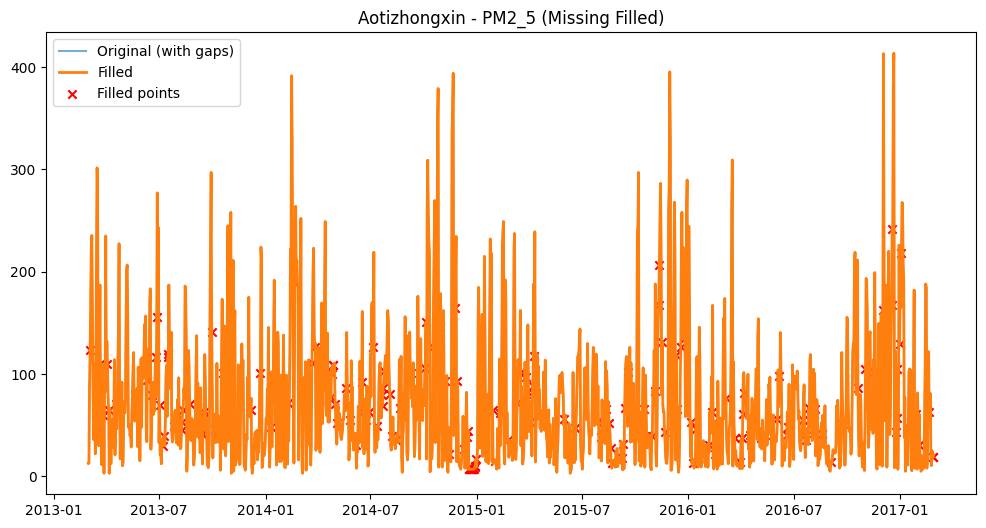

In [104]:
plt.figure(figsize=(12,6))
plt.plot(series, label="Original (with gaps)", alpha=0.6)
plt.plot(series_filled, label="Filled", linewidth=2)

# Mark missing points
missing_mask = series.isna()
plt.scatter(series.index[missing_mask], series_filled[missing_mask], 
            color="red", marker="x", label="Filled points")

plt.title(f"{station} - {target} (Missing Filled)")
plt.legend()
plt.show()

In [105]:
# I will keep a separate detector for each station because each location can drift at a different time.


def init_detectors(delta: float = 0.002):
    """
    Returns a dict {station_name: ADWIN_instance}
    """
    return defaultdict(lambda: river_drift.ADWIN(delta=delta))



In [106]:
def init_online_models():
    """
    Returns a dict {station: model_pipeline}
    Each pipeline: StandardScaler → LinearRegression (you can swap for any other model)
    """
    return defaultdict(
        lambda: preprocessing.StandardScaler() | linear_model.LinearRegression()
    )


In [107]:
def stream_with_drift(
    daily_df: pd.DataFrame,
    target: str = "PM2_5",
    delta: float = 0.002,
    drift_cooldown: pd.Timedelta = pd.Timedelta(days=30)
):
    """
    Runs a streaming drift detector for every station.
    Returns a dict:
        {
            station: {
                "change_points": [timestamp, ...],
                "model": last_trained_river_model,
                "mae": running_MAE_metric
            },
            ...
        }
    """
    # 1️⃣ Initialise per‑station objects
    detectors = init_detectors(delta=delta)          # ADWIN per station
    models    = init_online_models()                # optional online predictor
    mae_metric = defaultdict(metrics.MAE)           # keep a running MAE per station

    # 2️⃣ Keep track of the *last* change point per station so we do not
    #    flood the output with many detections that happen within a short window.
    last_change = defaultdict(lambda: pd.Timestamp.min)

    # 3️⃣ Stream through the data
    for ts, station, x, y in daily_stream(daily_df, target_col=target):
        # ---- Drift detection -------------------------------------------------
        det = detectors[station]
        det.update(y)                               # ADWIN works on a *scalar*

        if det.change_detected:
            # Enforce a cooldown so that a single regime shift does not
            # generate dozens of consecutive alerts.
            if ts - last_change[station] > drift_cooldown:
                print(f"[{ts.date()}] Drift detected @ {station}")
                last_change[station] = ts

                # ---- React to drift ------------------------------------------------
                # Example actions:
                #   1) Reset the online model (start fresh for the new regime)
                #   2) Flag the point so you can later split the SARIMAX training data
                models[station] = init_online_models()[station]   # fresh pipeline
                mae_metric[station] = metrics.MAE()               # reset MAE counter

        # ---- Online model update (optional) ---------------------------------
        # Skip if y is NaN (you already imputed, but just in case)
        if not pd.isna(y):
            model = models[station]
            model = model.learn_one(x, y)          # River’s online learning API
            models[station] = model                # store back

            # Update running MAE (use the model’s prediction)
            y_pred = model.predict_one(x)
            mae_metric[station].update(y_true=y, y_pred=y_pred)

    # -------------------------------------------------
    # Gather results
    # -------------------------------------------------
    results = {}
    for station in detectors.keys():
        results[station] = {
            "change_points": [ts for ts in daily_df.index
                              if ts in last_change.values()],  # simple view
            "model": models[station],
            "final_mae": mae_metric[station].get()
        }
    return results


In [108]:
def sarimax_per_regime(
    daily_df: pd.DataFrame,
    station: str,
    target: str,
    change_points: list,
    order=(2, 1, 2),
    seasonal_order=(1, 1, 1, 12),
    min_len=pd.Timedelta(days=60)   # require at least two months of data
):
    """
    Returns a list of (start, end, fitted_model, mae_on_last_window)
    """
    # Add the very first and very last timestamps to the list so we have closed intervals
    cp = sorted(change_points)
    cp = [daily_df.index.min()] + cp + [daily_df.index.max()]

    models_info = []

    for start, end in zip(cp[:-1], cp[1:]):
        seg = daily_df[(daily_df.index >= start) & (daily_df.index < end) &
                       (daily_df["station"] == station)]

        if seg.empty or (seg.index[-1] - seg.index[0]) < min_len:
            continue

        y = seg[target].dropna()
        if len(y) < 30:               # need a minimal number of observations
            continue

        # Fit SARIMAX on the whole segment (you can also keep a validation slice)
        model = SARIMAX(y,
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        fit = model.fit(disp=False)

        # Quick out‑of‑sample check: forecast the last 14 days and compute MAE
        test_len = 14
        if len(y) > test_len:
            train, test = y.iloc[:-test_len], y.iloc[-test_len:]
            forecast = fit.get_forecast(steps=test_len)
            mae = mean_absolute_error(test, forecast.predicted_mean)
        else:
            mae = None

        models_info.append({
            "start": start,
            "end": end,
            "model": fit,
            "MAE_last_window": mae
        })

    return models_info


In [109]:
station = "Aotizhongxin"
target  = "PM2_5"

# 1️⃣  Run the streaming drift detector
drift_res = stream_with_drift(daily_df, target=target, delta=0.002)

# 2️⃣  Pull the change‑point list for the station of interest
change_pts = drift_res[station]["change_points"]

# 3️⃣  Fit SARIMAX on each stable regime
regime_models = sarimax_per_regime(daily_df, station, target, change_pts)

print(f"\nStation {station} → {len(regime_models)} stable regimes discovered")
for i, info in enumerate(regime_models, 1):
    print(f" Regime {i}: {info['start'].date()} → {info['end'].date()}, "
          f"MAE(last 14d) = {info['MAE_last_window']:.3f}")


AttributeError: 'ADWIN' object has no attribute 'change_detected'

Classical: ARIMA, SARIMA, Holt-Winters.

Machine Learning: XGBoost, RandomForest with lag features.

Deep Learning: LSTMs, Temporal CNNs, Transformers.